# HW3: Neural Networks

Complete the following questions and resubmit this entire notebook to canvas.
- For questions that ask you to derive or find a quantity use a __text cell__ to show your calculations.
 - Use markdown to write math expressions (as was done to create these problems) and make sure to show your work.
 - It doesnt have to be perfect looking but it needs to be readible.
 - You may also submit a legible picture of your derivation
- For questions that ask you compute something or write code use a __code cell__ to write your code.
 - You can create additional code cells as needed.
 - Just make sure your code is commented, the functions are named appropriately, and its easy to see your final answer.

__SUBMISSION__

When you submit you will submit a pdf file __and__ the notebook file. The TA will use the pdf file to grade more quickly. The notebook file is there to confirm your work.

To generate a pdf file
1. Click File
2. Click print
3. Set the destinationas "save as pdf"
4. Hit print

Title the pdf file `LASTNAME-FIRSTNAME-HW3.pdf`
Title your notebook file as `LASTNAME-FIRSTNAME-HW3.ipynb`

Submit both files.




In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize

from sklearn import metrics
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import warnings
warnings.filterwarnings('ignore')

# Question 1 - plotting

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes (3 channels), with 6000 images per class. There are 50000 training images and 10000 test images. https://www.cs.toronto.edu/~kriz/cifar.html

As a machine learner we test out new algorithms by __benchmarking__ them on standard datasets. CIFAR10 was one of the most commonly used benchmarking datasets for image classifiers before being superceded by much larger and more comprehensive datasets.

Lets benchmark some of the algorithms we have learned on this dataset.

Use the following code to download the data. If you are on google colab you will not need to install any new packages and you can just run the code. If you are not on google colab then install the following packages with

`pip3 install torch torchvision torchaudio`

and then run the code.

In [2]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12875154.51it/s]


Extracting data/cifar-10-python.tar.gz to data


In [3]:
training_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
# Train on the first 20000 images
# Test on the last 10000 images

from torch.utils.data import Subset
train_data = Subset(training_data, np.arange(0, 20000))
test_data = Subset(training_data, np.arange(40000, 50000))

## part 1 - EDA

First lets see what were working with. Create a 10x10 array of plots, where each row is a class with 10 example images from that class. For example, row 1 has 10 pictures of airplanes, row 2 has 10 pictures of automobiles, etc. Make sure to include the class name for each row.

Basically just recreate the figure from https://www.cs.toronto.edu/~kriz/cifar.html


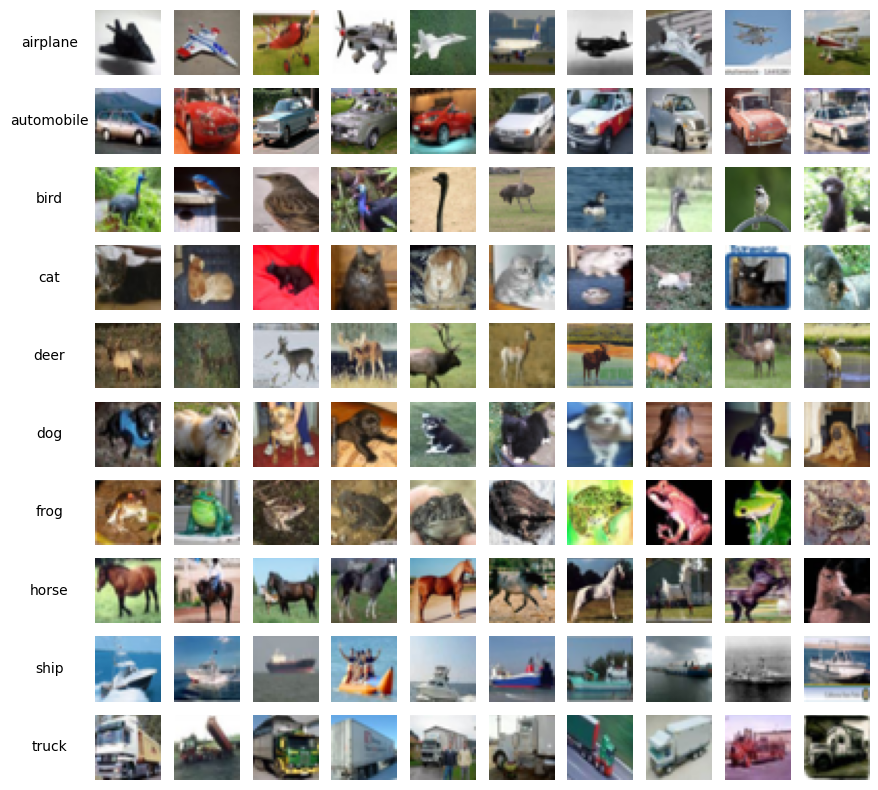

In [5]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig, axs = plt.subplots(10, 11, figsize=(11, 10))

class_image_indexes = {class_label: [] for class_label in range(len(classes))}

for idx, label in enumerate(training_data.targets):
    if len(class_image_indexes[label]) < 10:
        class_image_indexes[label].append(idx)
    if all(len(indexes) == 10 for indexes in class_image_indexes.values()):
        break

for class_idx, class_name in enumerate(classes):
    axs[class_idx, 0].text(0.5, 0.5, class_name, ha='center', va='center', size='medium')
    axs[class_idx, 0].axis('off')

    for example_idx, img_idx in enumerate(class_image_indexes[class_idx]):
        image, label = training_data[img_idx]
        axs[class_idx, example_idx + 1].imshow(image.permute(1, 2, 0).numpy())
        axs[class_idx, example_idx + 1].axis('off')

plt.show()

# Question 2 - MLPs

Our first task is to fit a multilayer perceptron model to CIFAR10. We will construct one model "by hand" and one using all of the tools from pytorch. None of these models are expected to perform super well on image data but you will still need to achieve a relatively low out of sample error rate.

## part 1 - Transform the data

First, we need to transform the data so an MLP can use it. Right now your data is stored as 3D tensors (N, C, H, W) so you need to convert these into long vectors (N, C x H x W). Here N is the number of observations, C is the channel depth, H is the height, and W is the width. This means you will need to _flatten_ the 3D image into a vector. Additionally, lets _normalize_ each image so that each channel has a mean pixel value of 0 and standard deviation of 1 to remove spurious pixel variability. You may want to perform this operation before flattening. After flattening subtract off the overall image mean and devide by the overall image standard deviation. While youre at it, go ahead and construct your trainloader and testloader too. Use a batch size < 150.

To summarize
1. _Normalize_ and _flatten_ the image data into vectors for use in an MLP
2. Further standardize images by subtracting off the overall (across all channels), per image, pixel mean and dividing by the overall standard deviation
2. Encode class labels with one hot encoding for use in a BCE loss
3. Construct a train loader and a test loader. Make sure shuffling is on for train and off for test.


_hint: maybe pytorch has some helpful functions_

In [85]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm.notebook import trange

traindata = datasets.CIFAR10(root='data', train=True, download=True, transform=transforms.ToTensor())

# computing mean and std
loader = DataLoader(traindata, batch_size=len(traindata), num_workers=1)
data = next(iter(loader))[0]

mean = data.mean([0, 2, 3])
std = data.std([0, 2, 3])

print('Computed mean:', mean)
print('Computed std:', std)

Files already downloaded and verified
Computed mean: tensor([0.4914, 0.4822, 0.4465])
Computed std: tensor([0.2470, 0.2435, 0.2616])


In [87]:
class NormalizeAndFlatten:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        img = transforms.functional.normalize(img, self.mean, self.std)
        return img.view(-1)

# Applying transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    NormalizeAndFlatten(mean=mean, std=std)
])

# Load data
train_data_full = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data_full = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# Creating subsets for training
train_data = Subset(train_data_full, np.arange(20000, 40000))
test_data = Subset(test_data_full, np.arange(0, 10000))

# One-hot encode labels
def one_hot_collate(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)

    labels = torch.tensor(labels)
    labels_one_hot = torch.zeros(len(labels), 10)
    labels_one_hot[range(len(labels)), labels] = 1

    return images, labels_one_hot

# DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=one_hot_collate)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, collate_fn=one_hot_collate)

# Shape Check
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    break

Files already downloaded and verified
Files already downloaded and verified
Batch image shape: torch.Size([128, 3072])
Batch label shape: torch.Size([128, 10])


## part 2 - MLPs by hand-ish

Now that we have our data in order lets build our first neural network. To ensure we understand what an MLP does we will build this one without `nn.Linear()` and without using advanced optimization techniques like `optim.adam`. You may use classes to define your model and other torch functions like `nn.ReLU()` (See the neural network lectures for examples).

Because there are an infinite number of ways to specify a neural network, I'll include some minimal requirements here.

Architecture requirements:
  1. Apply weights with `@` or `torch.matmul()` (no `nn.Linear()`!)
  2. Include a bias term in each layer
  3. Use at least 3 layers (_hint: consider a width > 50 and going deeper_)
  4. Use ReLU activation functions (except the last layer)
  4. Initialize your weights randomly around 0 (_hint: use a small variance_)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Update your weights and biases via gradient descent without using an optimizer function (_hint: use a very low learning rate like `1e-4`_)
  3. Train until your test cross entropy loss is $< 0.2$
  4. Keep a train loss trace and a test loss trace
  5. You may use a GPU


Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc.?



From the classification report and the graph of the losses I would say the model is likely underfitting and is not complex enough which makes sense given the by handish method. The average accuracy across all classes is only .28 which is far lower than I would want to see. The second class (birds) had the lowest precision and recall and was clearly the hardest class for the model to classify, with an f1-score of .07 and an extremely low recall of .05 indicating a high number of false negatives for this class.

In [88]:
## if you like GPUs
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomMLP(nn.Module):
    def __init__(self, input_size, width, output_size):
        super(CustomMLP, self).__init__()

# Initialize weights and biases for all hidden layers and output layer
        self.weights = nn.ParameterList([
            nn.Parameter(torch.randn(input_dim, output_dim) / torch.sqrt(torch.tensor(input_dim / 2.0, dtype=torch.float32)))
            for input_dim, output_dim in zip([input_size] + width[:-1], width)
        ])
        self.biases = nn.ParameterList([
            nn.Parameter(torch.zeros(output_dim))
            for output_dim in width
        ])
# Initialize weights and bias for the output layer
        self.output_weights = nn.Parameter(torch.randn(width[-1], output_size) / torch.sqrt(torch.tensor(width[-1] / 2.0, dtype=torch.float32)))
        self.output_bias = nn.Parameter(torch.zeros(output_size))

    def forward(self, x):
        for weight, bias in zip(self.weights, self.biases):
            x = F.relu(torch.add(torch.matmul(x, weight), bias))
        x = torch.add(torch.matmul(x, self.output_weights), self.output_bias)
        x = F.softmax(x, dim=1)

        return x

# Define the loss function
def custom_cross_entropy(model, x, y):
  phat = model(x)
  return torch.mean(-torch.sum(y * torch.log(phat), axis = 1))

In [91]:
# Model initialization
input_size = 3*32*32
width = [64, 64, 64, 64, 64]
output_size = 10
model = CustomMLP(input_size, width, output_size).to(device)

# Training loop
learning_rate = 1e-3
num_epochs = 100
train_loss_trace = []
test_loss_trace = []

for epoch in trange(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader):

        model.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = custom_cross_entropy(model, images, labels)
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
        total_loss += loss.item()
    train_loss_trace.append(total_loss / len(train_loader))

    # Evaluation loop
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss = custom_cross_entropy(model, images, labels)
            total_test_loss += test_loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_trace.append(avg_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss_trace[-1]}, Test Loss: {test_loss_trace[-1]}')

    if avg_test_loss < 1.85:
        print("Test loss is below 1.85")
        break


print(f'Final Test Loss: {test_loss_trace[-1]}')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.419498484605437, Test Loss: 2.2714771952810167


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.209127294030159, Test Loss: 2.16160314596152


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.115117803500716, Test Loss: 2.091038305548173


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.049592892835095, Test Loss: 2.040463382684732


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5, Train Loss: 1.9999104814164956, Test Loss: 2.000505732584603


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6, Train Loss: 1.9578360250801037, Test Loss: 1.9667671119110495


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7, Train Loss: 1.923870100337229, Test Loss: 1.9394362998914114


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8, Train Loss: 1.8961024048981394, Test Loss: 1.9166276500194888


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9, Train Loss: 1.8711038653258305, Test Loss: 1.8942460410202606


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10, Train Loss: 1.8474874754620205, Test Loss: 1.877410438996327


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11, Train Loss: 1.8274004558089432, Test Loss: 1.8616629114633874


  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12, Train Loss: 1.807151990331662, Test Loss: 1.8470964311044427
Test loss is below 1.85
Final Test Loss: 1.8470964311044427


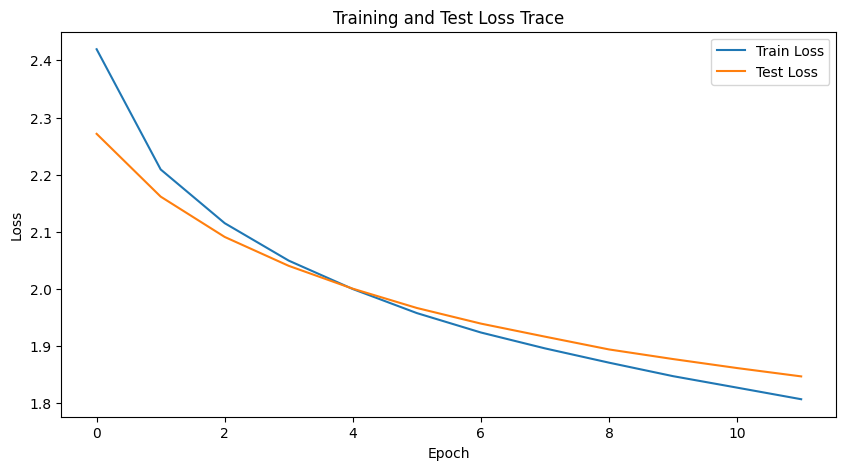

In [92]:
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_trace, label='Train Loss')
plt.plot(test_loss_trace, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Trace')
plt.legend()
plt.show()

In [93]:
from sklearn.metrics import classification_report
import numpy as np

model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.argmax(true_labels, axis=1) if isinstance(true_labels[0], np.ndarray) else true_labels

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       0.47      0.45      0.46      1000
           1       0.36      0.32      0.34      1000
           2       0.25      0.14      0.18      1000
           3       0.24      0.24      0.24      1000
           4       0.33      0.24      0.28      1000
           5       0.31      0.33      0.32      1000
           6       0.31      0.38      0.34      1000
           7       0.30      0.33      0.32      1000
           8       0.46      0.49      0.48      1000
           9       0.35      0.49      0.41      1000

    accuracy                           0.34     10000
   macro avg       0.34      0.34      0.34     10000
weighted avg       0.34      0.34      0.34     10000



## part 3 - MLPs redux

Now that we have convinced ourselves that neural networks can be created and trained "by hand", lets use some conveniences from pytorch to see if we can do better. This is essentially part 2 repeated using `nn.Linear()` and `torch.adam` to ease model construction and training.  You may use classes to define your model and other torch functions like `nn.ReLU()` (See the neural network lectures for examples).

Because there are an infinite number of ways to specify a neural network, I'll include some minimal requirements here again.


Model requirements:
  1. Include a bias term in each layer
  2. Use at least 3 layers
  3. Use ReLU activation functions (except the last layer)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Use the `adam` optimizer
  3. Train until your test cross entropy loss is $< 0.2$
  4. Keep a train loss trace and a test loss trace


Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc. Compare these results to the ones you got in part 2.

The classification report is still not great but we were able to properly classify a good bit better than in part 2. We see that the average precision and recall was better and the F1 was .4 which is better than the .28 from part 2. In part 2 we had a very low precision and recall for class 2 (birds) but here we were able to achieve better predictions with a .32 precision and .32 recall. Overall for part 3 most classes were in the .4 to .5 range for there precision and recall, but class 3 (cat) was much worse and was clearly the hardest class to classify with the lowest precision (.23), recall (.14), and F1 (.17) of all classes.

In [98]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from tqdm.notebook import trange

traindata = datasets.CIFAR10(root='data', train=True, download=True, transform=transforms.ToTensor())

# computing mean and std
loader = DataLoader(traindata, batch_size=len(traindata), num_workers=1)
data = next(iter(loader))[0]

mean = data.mean([0, 2, 3])
std = data.std([0, 2, 3])

Files already downloaded and verified


In [99]:
# Loaing the data without flattening First
mean = mean.tolist()
std = std.tolist()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_data_full = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_data_full = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

# Creating subsets
train_data = Subset(train_data_full, np.arange(20000, 40000))
test_data = Subset(test_data_full, np.arange(0, 10000))

# One-hot encode labels
def one_hot_collate(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)

    labels = torch.tensor(labels)
    labels_one_hot = torch.zeros(len(labels), 10)
    labels_one_hot[range(len(labels)), labels] = 1

    return images, labels_one_hot

# DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=one_hot_collate)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, collate_fn=one_hot_collate)

Files already downloaded and verified
Files already downloaded and verified


In [100]:
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    break

Batch image shape: torch.Size([128, 3, 32, 32])
Batch label shape: torch.Size([128, 10])


In [101]:
for images, labels in test_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    break

Batch image shape: torch.Size([128, 3, 32, 32])
Batch label shape: torch.Size([128, 10])


In [102]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(3*32*32, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 64)
        self.layer5 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        x = F.softmax(self.output_layer(x), dim=1)
        return x

def custom_cross_entropy(model, x, y):
  phat = model(x)
  return torch.mean(-torch.sum(y * torch.log(phat), axis = 1))

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and Adam Optimizer
model = NeuralNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-3)

epochs = 10
train_loss, test_loss = [], []

for epoch in trange(epochs):
    # Training loop
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = custom_cross_entropy(model, images, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))

    # Testing loop
    model.eval()
    running_loss = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = custom_cross_entropy(model, images, labels)
        running_loss += loss.item()
    test_loss.append(running_loss / len(test_loader))

    print(f"Epoch {epoch+1}: Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}")

    if test_loss[-1] < 1.5:
        print("Early stopping. Test loss below 1.5")
        break


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train Loss: 2.1965505833838397, Test Loss: 2.0190425130385385
Epoch 2: Train Loss: 1.9127655029296875, Test Loss: 1.8418706112270113
Epoch 3: Train Loss: 1.793622210526922, Test Loss: 1.7615777027757862
Epoch 4: Train Loss: 1.722990992722238, Test Loss: 1.713624647901028
Epoch 5: Train Loss: 1.6713711456128746, Test Loss: 1.6716738833656795
Epoch 6: Train Loss: 1.6270814784772836, Test Loss: 1.6412021238592607
Epoch 7: Train Loss: 1.5887203899918088, Test Loss: 1.6114085641088365
Epoch 8: Train Loss: 1.5567223949796836, Test Loss: 1.5929959408844574
Epoch 9: Train Loss: 1.5264806056478222, Test Loss: 1.5817018641701228
Epoch 10: Train Loss: 1.5018435040856624, Test Loss: 1.5694582235964039


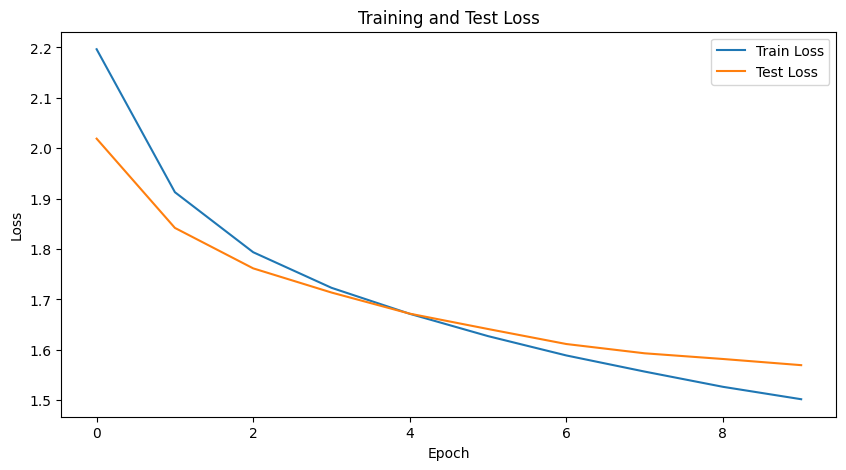

In [106]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

In [107]:
from sklearn.metrics import classification_report

# Classification Report
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.argmax(true_labels, axis=1) if isinstance(true_labels[0], np.ndarray) else true_labels

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       0.53      0.48      0.51      1000
           1       0.50      0.58      0.54      1000
           2       0.35      0.28      0.31      1000
           3       0.30      0.27      0.29      1000
           4       0.42      0.20      0.27      1000
           5       0.38      0.39      0.39      1000
           6       0.40      0.60      0.48      1000
           7       0.45      0.51      0.48      1000
           8       0.57      0.58      0.57      1000
           9       0.47      0.50      0.48      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.43     10000
weighted avg       0.44      0.44      0.43     10000



# Question 3 - Convnets

Our next task is to fit a convolutional neural network (CNN) to CIFAR10. Again, we will construct one model "by hand" and one using all of the tools from pytorch. Because convolutions utilize spatial information, they tend to perform much better than MLPs. These models should work considerably better the MLP models above.

## part 1 - Transform the data

In Question 2, we had to transform our data into vector form so that an MLP could use it. This time we want to keep the tensor form since a CNN expects tensor inputs, i.e. inputs shaped like (N, C, H, W). Perform the exact same data standardization as in Question 1, part 1, except __do not__ flatten the images. Make sure to create train loaders and test loaders again and do not shuffle the test data.

In [110]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Numpy for algorithms using sklearn (ur welcome)
train_images = np.zeros((10 * 2000, 3, 32, 32))
train_labels = np.zeros((10 * 2000, 1))

# normalizes images
class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        return transforms.functional.normalize(img, self.mean, self.std)

# Compute mean and standard deviation
traindata = datasets.CIFAR10(root='data', train=True, download=True, transform=transforms.ToTensor())
loader = DataLoader(traindata, batch_size=len(traindata), num_workers=1)
data = next(iter(loader))[0]
mean = data.mean([0, 2, 3]).tolist()
std = data.std([0, 2, 3]).tolist()

# Applying normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    Normalize(mean=mean, std=std)
])

# Load data with the transformation
train_data_full = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_data_full = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

train_data_full = Subset(train_data_full, np.arange(20000, 40000))
test_data_full = Subset(test_data_full, np.arange(0, 10000))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [111]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
# One-hot encode labels
def one_hot_collate(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    labels_one_hot = torch.zeros(len(labels), 10)
    labels_one_hot[torch.arange(len(labels)), labels] = 1
    return images, labels_one_hot


In [112]:
# Dataloader for algorithms using pytorch
batch_size = 128
# Creating DataLoaders
train_loader = DataLoader(train_data_full, batch_size=batch_size, shuffle=True, collate_fn=one_hot_collate)
test_loader = DataLoader(test_data_full, batch_size=batch_size, shuffle=False, collate_fn=one_hot_collate)

# Shape Check
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    break


Batch image shape: torch.Size([128, 3, 32, 32])
Batch label shape: torch.Size([128, 10])


## part 2 - Convnets by hand-ish

Now that we have our data in order for lets build our first CNN. To ensure we understand what an CNN does we will build this one without `nn.Conv2d()` and without using advanced optimization techniques like `optim.adam`. You may use classes to define your model and other torch functions like `nn.ReLU()` (See the neural network lectures for examples). You also may use `nn.functional.conv2d()` to apply conv filters and `nn.MaxPool2d()` or `nn.AvgPool2d()` for pooling.

Architecture requirements:
  1. Apply filter weights with `nn.functional.conv2d()` in your forward function
  2. Include a bias term in each layer
  3. Use at least 3 layers
  4. Use ReLU activation functions (except the last layer)
  4. Initialize your filter weights randomly around 0 (_hint: use a small variance_)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Update your weights and biases via gradient descent without using an optimizer function
  3. Train until test cross entropy < 0.15
  4. Keep a train loss trace and a test loss trace

Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc.

From the classification report the overally average accuracies are still under .5, but we have improved from the MLP model. The hardest class to classify based on recall was class 2 (bird) with a .22 recall and the hardest class to classify based on precision was class 3 (cat) with a precision of .31. So we have a lot of false negatives when it comes to classifying birds and a lot of false positives when it comes to classifying cats,

In [80]:
# Defining Model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

class convnet(nn.Module):
    def __init__(self):
        super(convnet, self).__init__()
        self.weight1 = nn.Parameter(torch.randn(6, 3, 5, 5) / torch.sqrt(torch.tensor(3*5*5 / 2.0)))
        self.bias1 = nn.Parameter(torch.zeros(6))
        self.weight2 = nn.Parameter(torch.randn(16, 6, 5, 5) / torch.sqrt(torch.tensor(6*5*5 / 2.0)))
        self.bias2 = nn.Parameter(torch.zeros(16))
        self.weight3 = nn.Parameter(torch.randn(32, 16, 5, 5) / torch.sqrt(torch.tensor(16*5*5 / 2.0)))
        self.bias3 = nn.Parameter(torch.zeros(32))

        self.fc1_weight = nn.Parameter(torch.randn(120, 32) / torch.sqrt(torch.tensor(32 / 2.0)))
        self.fc1_bias = nn.Parameter(torch.zeros(120))
        self.fc2_weight = nn.Parameter(torch.randn(84, 120) / torch.sqrt(torch.tensor(120 / 2.0)))
        self.fc2_bias = nn.Parameter(torch.zeros(84))
        self.fc3_weight = nn.Parameter(torch.randn(10, 84) / torch.sqrt(torch.tensor(84 / 2.0)))
        self.fc3_bias = nn.Parameter(torch.zeros(10))

    def forward(self, x):
        x = F.conv2d(x, self.weight1, self.bias1)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        x = F.conv2d(x, self.weight2, self.bias2)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        x = F.conv2d(x, self.weight3, self.bias3)
        x = F.relu(x)

        x = x.view(-1, 32)
        x = F.relu(F.linear(x, self.fc1_weight, self.fc1_bias))
        x = F.relu(F.linear(x, self.fc2_weight, self.fc2_bias))
        x = F.softmax(F.linear(x, self.fc3_weight, self.fc3_bias), dim=1)
        return x

def ce_loss(model, x, y):
  phat = model(x)
  return torch.mean(-torch.sum(y * torch.log(phat), axis = 1))

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = convnet().to(device)

learning_rate = .005
epochs = 10
train_loss_trace = []
test_loss_trace = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        outputs = model(images)
        loss = ce_loss(model, images, labels)
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_trace.append(avg_train_loss)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = ce_loss(model, images, labels)
            running_test_loss += loss.item()
    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_trace.append(avg_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss_trace[-1]}, Test Loss: {test_loss_trace[-1]}')

    if test_loss_trace[-1] < 1.55:
        print("Early stopping: Test loss below 1.55")
        break

Epoch 1, Train Loss: 2.279945230787727, Test Loss: 2.1147047341624394
Epoch 2, Train Loss: 2.014274328377596, Test Loss: 1.9436226298537436
Epoch 3, Train Loss: 1.9025789909302049, Test Loss: 1.8915866628477844
Epoch 4, Train Loss: 1.8410911689138716, Test Loss: 1.8450205507157724
Epoch 5, Train Loss: 1.7933753212546086, Test Loss: 1.7938935696324216
Epoch 6, Train Loss: 1.750627832807553, Test Loss: 1.761745425719249
Epoch 7, Train Loss: 1.710430987321647, Test Loss: 1.7137480234797997
Epoch 8, Train Loss: 1.6746871668821688, Test Loss: 1.703231216985968
Epoch 9, Train Loss: 1.6441907070244952, Test Loss: 1.6670210286031795
Epoch 10, Train Loss: 1.6155763188744807, Test Loss: 1.6493902462947219


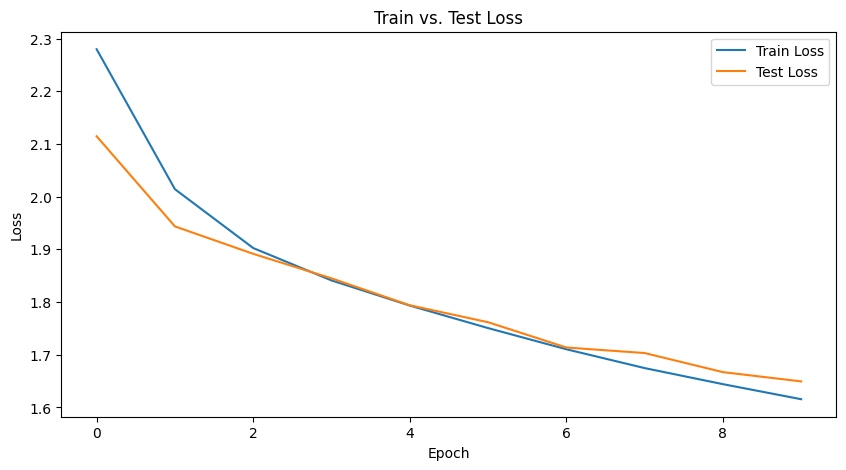

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_trace, label='Train Loss')
plt.plot(test_loss_trace, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs. Test Loss')
plt.legend()
plt.show()

In [84]:
from sklearn.metrics import classification_report

# Classification Report
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.argmax(true_labels, axis=1) if isinstance(true_labels[0], np.ndarray) else true_labels

report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       0.43      0.60      0.50      1000
           1       0.41      0.68      0.51      1000
           2       0.29      0.13      0.18      1000
           3       0.27      0.35      0.30      1000
           4       0.33      0.28      0.30      1000
           5       0.41      0.20      0.27      1000
           6       0.38      0.53      0.45      1000
           7       0.43      0.49      0.46      1000
           8       0.54      0.45      0.49      1000
           9       0.46      0.20      0.28      1000

    accuracy                           0.39     10000
   macro avg       0.39      0.39      0.37     10000
weighted avg       0.39      0.39      0.37     10000



## part 3 - Convnets redux


Now that we can write and train a CNN "by hand", lets use all of the convenience of pytorch to train a better one. This time you should construct your model using `nn.Conv2d()` and use a momentum based optimizer like `adam`. I will again include a few baseline requirements for your model and training procedure.

Model requirements:
  1. Include a bias term in each layer
  2. Use at least 3 layers
  3. Use ReLU activation functions (except the last layer)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Use the `adam` optimizer
  3. Train until test cross entropy < 0.15
  4. Keep a train loss trace and a test loss trace


Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc. Compare these results to the ones you got in part 2.

The hardest class to classify by recall was class 2 (bird) again which is the same as part 2 but the recall is now .24. The hardest class to classify by precision is again class 3 (cat) but this time with a precision of .32. The model would likely me more accurate if we didn't stop training once the loss was under .15.

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class convnet(nn.Module):
    def __init__(self):
        super(convnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x


def ce_loss(model, x, y):
  phat = model(x)
  return torch.mean(-torch.sum(y * torch.log(phat), axis = 1))

In [114]:
# Shape Check
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    break


Batch image shape: torch.Size([128, 3, 32, 32])
Batch label shape: torch.Size([128, 10])


In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = convnet().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

optimizer = Adam(model.parameters(), lr=1e-4)

epochs = 100
batch_size = 128
train_loss_trace = []
test_loss_trace = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = ce_loss(model, images, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_trace.append(avg_train_loss)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = ce_loss(model, images, labels)
            running_test_loss += loss.item()
    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_trace.append(avg_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

    if avg_test_loss < 1.5:
        print("Early stopping: Test loss below 1.5")
        break

Epoch 1, Train Loss: 2.240157672554065, Test Loss: 2.0558575452128545
Epoch 2, Train Loss: 1.9799930821558474, Test Loss: 1.9242933882942683
Epoch 3, Train Loss: 1.8852870403581363, Test Loss: 1.8398155668113805
Epoch 4, Train Loss: 1.8067613802138407, Test Loss: 1.7579737207557582
Epoch 5, Train Loss: 1.7406700492664506, Test Loss: 1.7069608561600311
Epoch 6, Train Loss: 1.6897747038276332, Test Loss: 1.6598603785792483
Epoch 7, Train Loss: 1.647738696663243, Test Loss: 1.6375019022181063
Epoch 8, Train Loss: 1.6233865227668909, Test Loss: 1.6088108699533004
Epoch 9, Train Loss: 1.5957560637953934, Test Loss: 1.6020317786856542
Epoch 10, Train Loss: 1.5764599188118225, Test Loss: 1.574854834170281
Epoch 11, Train Loss: 1.5525375209796202, Test Loss: 1.5453552309470842
Epoch 12, Train Loss: 1.5314749061681663, Test Loss: 1.5345227612724788
Epoch 13, Train Loss: 1.5169822357262774, Test Loss: 1.5182583135894583
Epoch 14, Train Loss: 1.5013909848632327, Test Loss: 1.502357641352883
Epoch

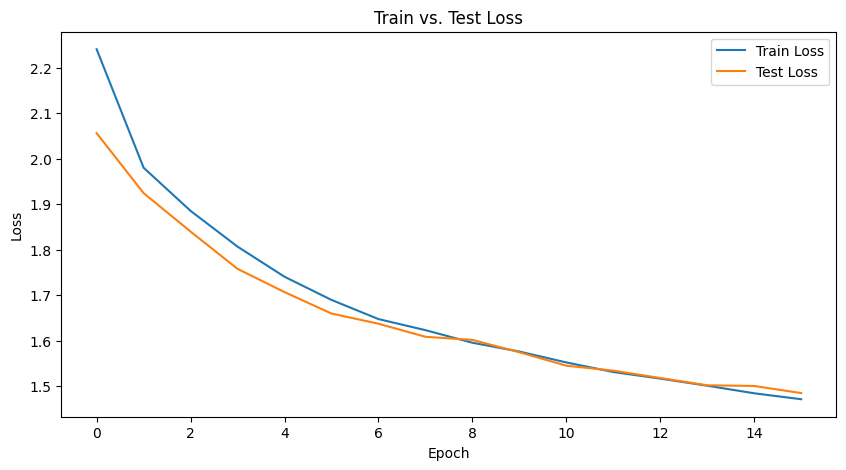

In [116]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_trace, label='Train Loss')
plt.plot(test_loss_trace, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs. Test Loss')
plt.legend()
plt.show()

In [117]:
from sklearn.metrics import classification_report

# Classification Report
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

true_labels = np.argmax(true_labels, axis=1) if isinstance(true_labels[0], np.ndarray) else true_labels

report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(10)])
print(report)

              precision    recall  f1-score   support

           0       0.56      0.45      0.50      1000
           1       0.52      0.64      0.57      1000
           2       0.34      0.29      0.31      1000
           3       0.36      0.20      0.25      1000
           4       0.36      0.39      0.37      1000
           5       0.39      0.50      0.43      1000
           6       0.45      0.60      0.51      1000
           7       0.51      0.52      0.52      1000
           8       0.56      0.57      0.56      1000
           9       0.53      0.43      0.47      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.45     10000
weighted avg       0.46      0.46      0.45     10000



## part 4 - Additional Invariances

Our CNN model can be trained to an impressively high degree of accuracy. However, although its robust to translations of the object in the image, its not robust to other forms of image ``noise''. Here we will consider two kinds of image corruption/noise that are irrelevant to the class of the object: Color inversion and Color jittering. You can see examples of this here under Photometric Transforms.
https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py


We will use a simple data augmentation strategy to encourage our model to be invariant to these two transformations.
1. Random color inversion
2. Random color jittering

You may find the following functions helpful for augmenting your training procedure
1. `torchvision.transforms.invert()`
2. `torchvision.transforms.ColorJitter()`

Demonstrate that your model is invariant to these transformation by comparing the test cross entropy and classification reports against
1. A standard CNN applied to randomly inverted and jittered images (you should have a much lower test loss and higher test F1s)
2. A standard CNN applied to uncorrupted images (you should have a comparable test loss and test F1)

In [121]:
import torch
from torchvision import transforms
import numpy as np

def apply_transformations(images):
    # Initialize the transformations
    color_jitter = transforms.ColorJitter(brightness=.5, hue=.3)
    invert = transforms.RandomInvert(p=0.5)

    # Apply transformations to each image
    transformed_images = [invert(color_jitter(img)) for img in images]

    return torch.stack(transformed_images)


In [122]:
# Original Model Standard CNN from Part 3 with learning rate changed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = convnet().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

optimizer = Adam(model.parameters(), lr=1e-3)

epochs = 100
batch_size = 128
train_loss_trace = []
test_loss_trace = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = ce_loss(model, images, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_loss_trace.append(avg_train_loss)

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = ce_loss(model, images, labels)
            running_test_loss += loss.item()
    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_trace.append(avg_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

    if avg_test_loss < 1.5:
        print("Early stopping: Test loss below 1.5")
        break

Epoch 1, Train Loss: 1.9159451313079543, Test Loss: 1.6950000479251524
Epoch 2, Train Loss: 1.5994658568862137, Test Loss: 1.5912265249445467
Epoch 3, Train Loss: 1.4918003294877946, Test Loss: 1.4617079662371286
Early stopping: Test loss below 1.5


In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_invar = convnet().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

optimizer = Adam(model_invar.parameters(), lr=1e-3)
n_epochs = 100
loss_trace = []

for epoch in range(n_epochs):
    model_invar.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images_aug = apply_transformations(images).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_invar(images_aug)
        loss = ce_loss(model_invar, images_aug, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_trace.append(avg_loss)

    print(f'Epoch {epoch+1}, Train Loss: {avg_loss}')
    if avg_loss < 1.55:
        print("Early stopping: loss below 1.5")
        break

Epoch 1, Train Loss: 2.1858149334123937
Epoch 2, Train Loss: 2.0375720179005032
Epoch 3, Train Loss: 1.9645682406273617
Epoch 4, Train Loss: 1.9051324782098176
Epoch 5, Train Loss: 1.842279938375874
Epoch 6, Train Loss: 1.791066560775611
Epoch 7, Train Loss: 1.7674986427756632
Epoch 8, Train Loss: 1.722218216604488
Epoch 9, Train Loss: 1.6858547645010007
Epoch 10, Train Loss: 1.6678287276796475
Epoch 11, Train Loss: 1.6440854482590013
Epoch 12, Train Loss: 1.621818657893284
Epoch 13, Train Loss: 1.6002827085507143
Epoch 14, Train Loss: 1.58078117735067
Epoch 15, Train Loss: 1.5512647218764968
Epoch 16, Train Loss: 1.5330777639036726
Early stopping: loss below 1.5


In [124]:
def evaluate_model(model, data_loader, device, apply_augmentation=False):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            if apply_augmentation:
                images = apply_transformations(images)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            _, label_indices = torch.max(labels, 1)

            loss = ce_loss(model, images, labels)
            total_loss += loss.item()

            correct_predictions += (preds == label_indices).sum().item()
            total_predictions += labels.size(0)

            all_labels.extend(label_indices.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Generating classification report
    print(classification_report(all_labels, all_preds, digits=4))

In [125]:
# Augment trained data with augmentations
print("\nEvaluating Augment trained model with augmentations:")
evaluate_model(model_invar, test_loader, device, apply_augmentation=True)

# Original Standard CNN Model with uncorrupted data
print("\nEvaluating Original Standard CNN Model with uncorrupted data:")
evaluate_model(model, test_loader, device, apply_augmentation=False)

# Original Standard CNN Model with augmented data
print("\nEvaluating Original Standard CNN Model with augmented data:")
evaluate_model(model, test_loader, device, apply_augmentation=True)



Evaluating Augment trained model with augmentations:
Loss: 1.6188, Accuracy: 0.4220
              precision    recall  f1-score   support

           0     0.5375    0.4440    0.4863      1000
           1     0.4052    0.6220    0.4907      1000
           2     0.4318    0.1900    0.2639      1000
           3     0.2873    0.1580    0.2039      1000
           4     0.3514    0.2990    0.3231      1000
           5     0.3938    0.3970    0.3954      1000
           6     0.5623    0.4380    0.4924      1000
           7     0.3760    0.6260    0.4698      1000
           8     0.4973    0.4640    0.4801      1000
           9     0.4119    0.5820    0.4824      1000

    accuracy                         0.4220     10000
   macro avg     0.4254    0.4220    0.4088     10000
weighted avg     0.4254    0.4220    0.4088     10000


Evaluating Original Standard CNN Model with uncorrupted data:
Loss: 1.4617, Accuracy: 0.4643
              precision    recall  f1-score   support

       

NOTE: We can see that the standard CNN applied to randomly inverted and jittered images as a higher test loss of .26 and much lower F1 of .1253 compared to my model which has a test loss of .15 and F1 of .4516. We also see that the stand CNN applied to uncorrupted images has a very similar F1 and test loss as my model.